# Computer Vision aided Driver Management System

In [60]:
import os
import csv
import cv2
import dlib
import socket
import radar
import matplotlib
import urllib.request
import numpy as np
import pandas as pd
import face_recognition as fr
import matplotlib.pyplot as plt
from requests import get
from radar import RadarClient
from imutils import face_utils
from datetime import datetime
from jupyterthemes import jtplot
from geopy.geocoders import Nominatim

In [61]:
pd.options.mode.chained_assignment = None

In [62]:
key_file = open("radar_api/key.txt","r")
api_key = key_file.read()

Getting face encodings for all faces stored in folder 'Face Data'.

In [63]:
path = 'Face Data'
faces = os.listdir("Face Data")
encodings = []
face_names = []
for face in faces :
    to_test = fr.load_image_file(f'{path}/{face}')
    to_test = cv2.cvtColor(to_test, cv2.COLOR_BGR2RGB)
    encoding = fr.face_encodings(to_test)[0]
    encodings.append(encoding)
    face_names.append(face.split(".")[0])

Making data frame containing all faces

In [64]:
df = pd.DataFrame(columns=['Name', 'Face-In', 'Face-Out', 'Duration', 'Origin', 'Destination'])
df['Name']= face_names
display(df)

,Name,Face-In,Face-Out,Duration,Origin,Destination
0,disaster_girl,NaN,NaN,NaN,NaN,NaN
1,pragnesh,NaN,NaN,NaN,NaN,NaN
2,tony_stark,NaN,NaN,NaN,NaN,NaN
3,xavier,NaN,NaN,NaN,NaN,NaN


<code>recognizer(frames, face_names, face_encodings)</code> : Accepts image frames and face_encodings and returns an integer ID of the best match.

In [65]:
def recognizer(frames, face_names, face_encodings) :
    frames_resized = cv2.resize(frames, (0,0), None, 0.20, 0.20)
    frames_resized = cv2.cvtColor(frames_resized, cv2.COLOR_BGR2RGB)
    loc_in_frame = fr.face_locations(frames_resized)
    encodings_in_frame = fr.face_encodings(frames_resized, loc_in_frame)
    
    for face_encoding in encodings_in_frame :
        face_distance = fr.face_distance(face_encodings, face_encoding)
        return np.argmin(face_distance)

<code>get_ip_location()</code> : Returns an object containing location data of current public IP address.

In [66]:
def get_ip_location():
    radar= RadarClient(api_key)
    ip_address = urllib.request.urlopen('https://ident.me').read().decode('utf8') 
    ip_location = radar.geocode.ip(ip=ip_address)
    
    return ip_location 

<code>distance_matrix(destination_address, origin_address)</code> : Accepts two addresses as arguments and returns an object containing route data connecting both addresses, if only one address is passed it considers IP location as default origin_address.

In [67]:
def distance_matrix(destination_address, origin_address=get_ip_location().city):
    loc = Nominatim(user_agent="GetLoc")
    radar = RadarClient(api_key)
    
    origin = loc.geocode(origin_address)
    origin = (origin.latitude, origin.longitude)
    destination = loc.geocode(destination_address)
    destination = (destination.latitude, destination.longitude)
    
    routes = radar.route.distance(origin, destination, modes="car")
    return routes.car

In [68]:
print(distance_matrix("surat, india", "delhi"))

<distance=1125.5 km duration=13 hrs 35 mins>


In [69]:
def calc_distances(f_id_list, data) :
    for i in f_id_list :
        data.loc[i, "Distance Travelled"] = distance_matrix(data.loc[i, "Origin"], data.loc[i, "Destination"]).distance.text 
        
    return data

<code>get_fuel_prices(city)</code>: Accepts address as argument, web-scraps and returns **real time** petrol price of that address/location.

In [70]:
def get_fuel_prices(city) :
    geolocator = Nominatim(user_agent = "http")
    loc = geolocator.geocode(city)
    state = loc[0].split(",")
    
    link_table = pd.read_csv("links/fuel_price_links.csv")
    link_table['States']=link_table.iloc[:,1]
    state_found = list(set(list(link_table['States'])).intersection(set(state)))[0]
    
    if state_found == None :
        print("City not in database.")
        return
    
    link = str(link_table[link_table['States']==state_found]['Links']).split('\n')[0]
    link = "https://www.goodreturns.in/"+str(link).split("/")[1]
    link = link.rstrip("\n")
    
    html_table = pd.read_html(link)
    ht = html_table[0]
    ht.columns = ht.iloc[0]
    ht = ht[1:]
    ht.loc[:, ["Today Price", 
               "Yesterday Price"]]=ht[ht.columns[1:]].replace('[\₹,]', '', regex=True).astype(float)
    print(f"From {link} petrol prices fetched as {ht['Today Price'].mean()}.")
    return ht["Today Price"].mean()

<code>calc_fare(f_id_list, dataframe, average)</code>: Accepts ID list of faces found in frame,  dataframe and mileage, using arguments it calculates fare levied and returns it as series object.

In [71]:
def calc_fare(f_id_list ,data, average):
    for i in f_id_list :
        if str(data['Distance Travelled'].dtype)=='object':
            data['Distance Travelled']=data['Distance Travelled'].str.replace(r'km', '').astype(float)
        data.loc[i, 'Fare'] = (get_fuel_prices(data.loc[i, 'Origin'])*data.loc[i, 'Distance Travelled'])/average
    return data['Fare']

In [72]:
webcam = cv2.VideoCapture(0)
i=0
f_id_list = []
dtime, dwell_time, face_in, face_out, origin_dict, destination_dict = [dict() for _ in range(6)]

while True :
    if i%1 == 0: #Condition for frame skip i%1 == 0 means no frame skips.
        success , frames = webcam.read()
        if i%50 == 0:
            f_id = recognizer(frames, face_names, encodings)
        if f_id!=None :
            cv2.putText(frames, 
                        face_names[f_id] ,(50, 50) , 
                        cv2.FONT_HERSHEY_COMPLEX,1.2, (0, 0, 0), 1)

            if f_id not in f_id_list :
                f_id_list.append(f_id)
                dtime[f_id] = datetime.now()
                dwell_time[f_id] = 0
                face_in[f_id] = datetime.now()
                origin_dict[f_id] = get_ip_location().city
            else :
                curr_time = datetime.now()
                old_time = dtime[f_id]
                time_diff = curr_time - old_time
                dtime[f_id] = datetime.now()
                sec = time_diff.total_seconds()
                dwell_time[f_id] += sec
                face_out[f_id] = datetime.now()
                #destination_dict = get_ip_location().city
                #The above line is commented for demonstration purposes, as it will return same address
                
        
        cv2.imshow("recognizer", frames)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            del webcam
            break
    i+=1

In [73]:
destination_dict = {0:"Mumbai", 1:"Delhi", 2:"Bangalore", 3:"Jaipur"}

In [74]:
for i in f_id_list :
    df.loc[i, "Face-In"] = face_in[i].strftime("%H:%M:%S")
    df.loc[i, "Face-Out"] = face_out[i].strftime("%H:%M:%S")
    df.loc[i, "Duration"] = dwell_time[i]
    df.loc[i, "Origin"] = origin_dict[i] + ", India"
    df.loc[i, "Destination"] = destination_dict[i] + ", India"

In [75]:
df = calc_distances(f_id_list, df)

In [76]:
df['Fare']=calc_fare(f_id_list, df, 20)

From https://www.goodreturns.in/petrol-price-in-gujarat-s12.html petrol prices fetched as 95.67757575757575.
From https://www.goodreturns.in/petrol-price-in-gujarat-s12.html petrol prices fetched as 95.67757575757575.


In [77]:
df

,Name,Face-In,Face-Out,Duration,Origin,Destination,Distance Travelled,Fare
0,disaster_girl,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,pragnesh,03:45:00,03:45:39,38.751796,"Ahmedabad, India","Delhi, India",916.3,4383.468133
2,tony_stark,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,xavier,03:45:24,03:45:33,9.546463,"Ahmedabad, India","Jaipur, India",658.0,3147.792242


### Disclaimer 

Parts of the code below heavily draws from the research paper [Real-Time Eye Blink Detection using Facial Landmarks](http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf). The parameters and check-conditions mentioned in the research paper are directly used in the code below. 

Formula for Eye Aspect Ratio (EAR) : 
$$EAR = \frac{||p_1-p_3||+||p_2-p_4||}{2||p_0-p_5||}$$

EAR is used to create driver road attentiveness profile.

In [78]:
ear_dict = dict()
time_dict = dict()

for f in range(len(face_names)):
    ear_dict[f] = []
    time_dict[f] = []

webcam = cv2.VideoCapture(0)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")


status = 0
check_status = 6
sleep_status = 0
drowsy_status = 0
active_status = 0
status_text=""
prev = " "

def norm(p1,p2):
    dist = np.linalg.norm(p1 - p2)
    return dist

def eye_aspect_ratio (p) :
    EAR = (norm(p[1],p[3]) + norm(p[2],p[4]))/(2.0*norm(p[0],p[5]))
    return EAR

def detect_blink(p):
    EAR = eye_aspect_ratio(p)
    if(EAR>0.25):
        return "open"
    elif(EAR>0.21 and EAR<=0.25):
        return "semi_open"
    else:
        return  "close"
i=0
while True:
    success, frames = webcam.read()
    grayscale = cv2.cvtColor(frames, cv2.COLOR_BGR2GRAY)
    faces = detector(grayscale)
    if i%50==0 :    ##Using Frame Skip for better performance
        f_id = recognizer(grayscale, face_names, encodings)
    i+=1
    if f_id!=None :
        for face in faces:
            facial_landmarks = predictor(grayscale, face)
            facial_landmarks = face_utils.shape_to_np(facial_landmarks)

            eye_landmarks = [facial_landmarks[36], facial_landmarks[37], facial_landmarks[38], facial_landmarks[41], facial_landmarks[40], facial_landmarks[39],
                             facial_landmarks[42], facial_landmarks[43], facial_landmarks[44], facial_landmarks[47], facial_landmarks[46], facial_landmarks[45]]

            l_eye = detect_blink(eye_landmarks[0:6])
            r_eye = detect_blink(eye_landmarks[6:12])

            if(l_eye=="close" or r_eye=="close"):
                sleep_status+=1
                drowsy_status=0
                active_status=0
                if(sleep_status>check_status):
                    status=0.5
                    status_text = "sleeping"

            elif(l_eye=="semi_open" or r_eye=="semi_open"):
                sleep_status=0
                active_status=0
                drowsy_status+=1
                if(drowsy_status>check_status):
                    status=1
                    status_text = "drowsy"
            
            elif(l_eye=="open" or r_eye=="open") :
                drowsy_status=0
                sleep_status=0
                active_status+=1
                if(active_status>check_status):
                    status=1.5
                    status_text = "active"

            time_dict[f_id].append(datetime.now())
            ear_dict[f_id].append(eye_aspect_ratio(eye_landmarks[0:6])+eye_aspect_ratio(eye_landmarks[6:12]))
            cv2.putText(frames, face_names[f_id], (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1.2, (0,0,0), 1)
            cv2.putText(frames, status_text,(50, 50) , cv2.FONT_HERSHEY_COMPLEX, 1.2, (0,0,0),1)

        for n in range(0, 12):
            (x,y) = eye_landmarks[n]
            cv2.circle(frames, (x, y), 1, (255, 255, 255), -1)

    cv2.imshow("Frame", frames)
    if cv2.waitKey(10) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            del webcam
            break

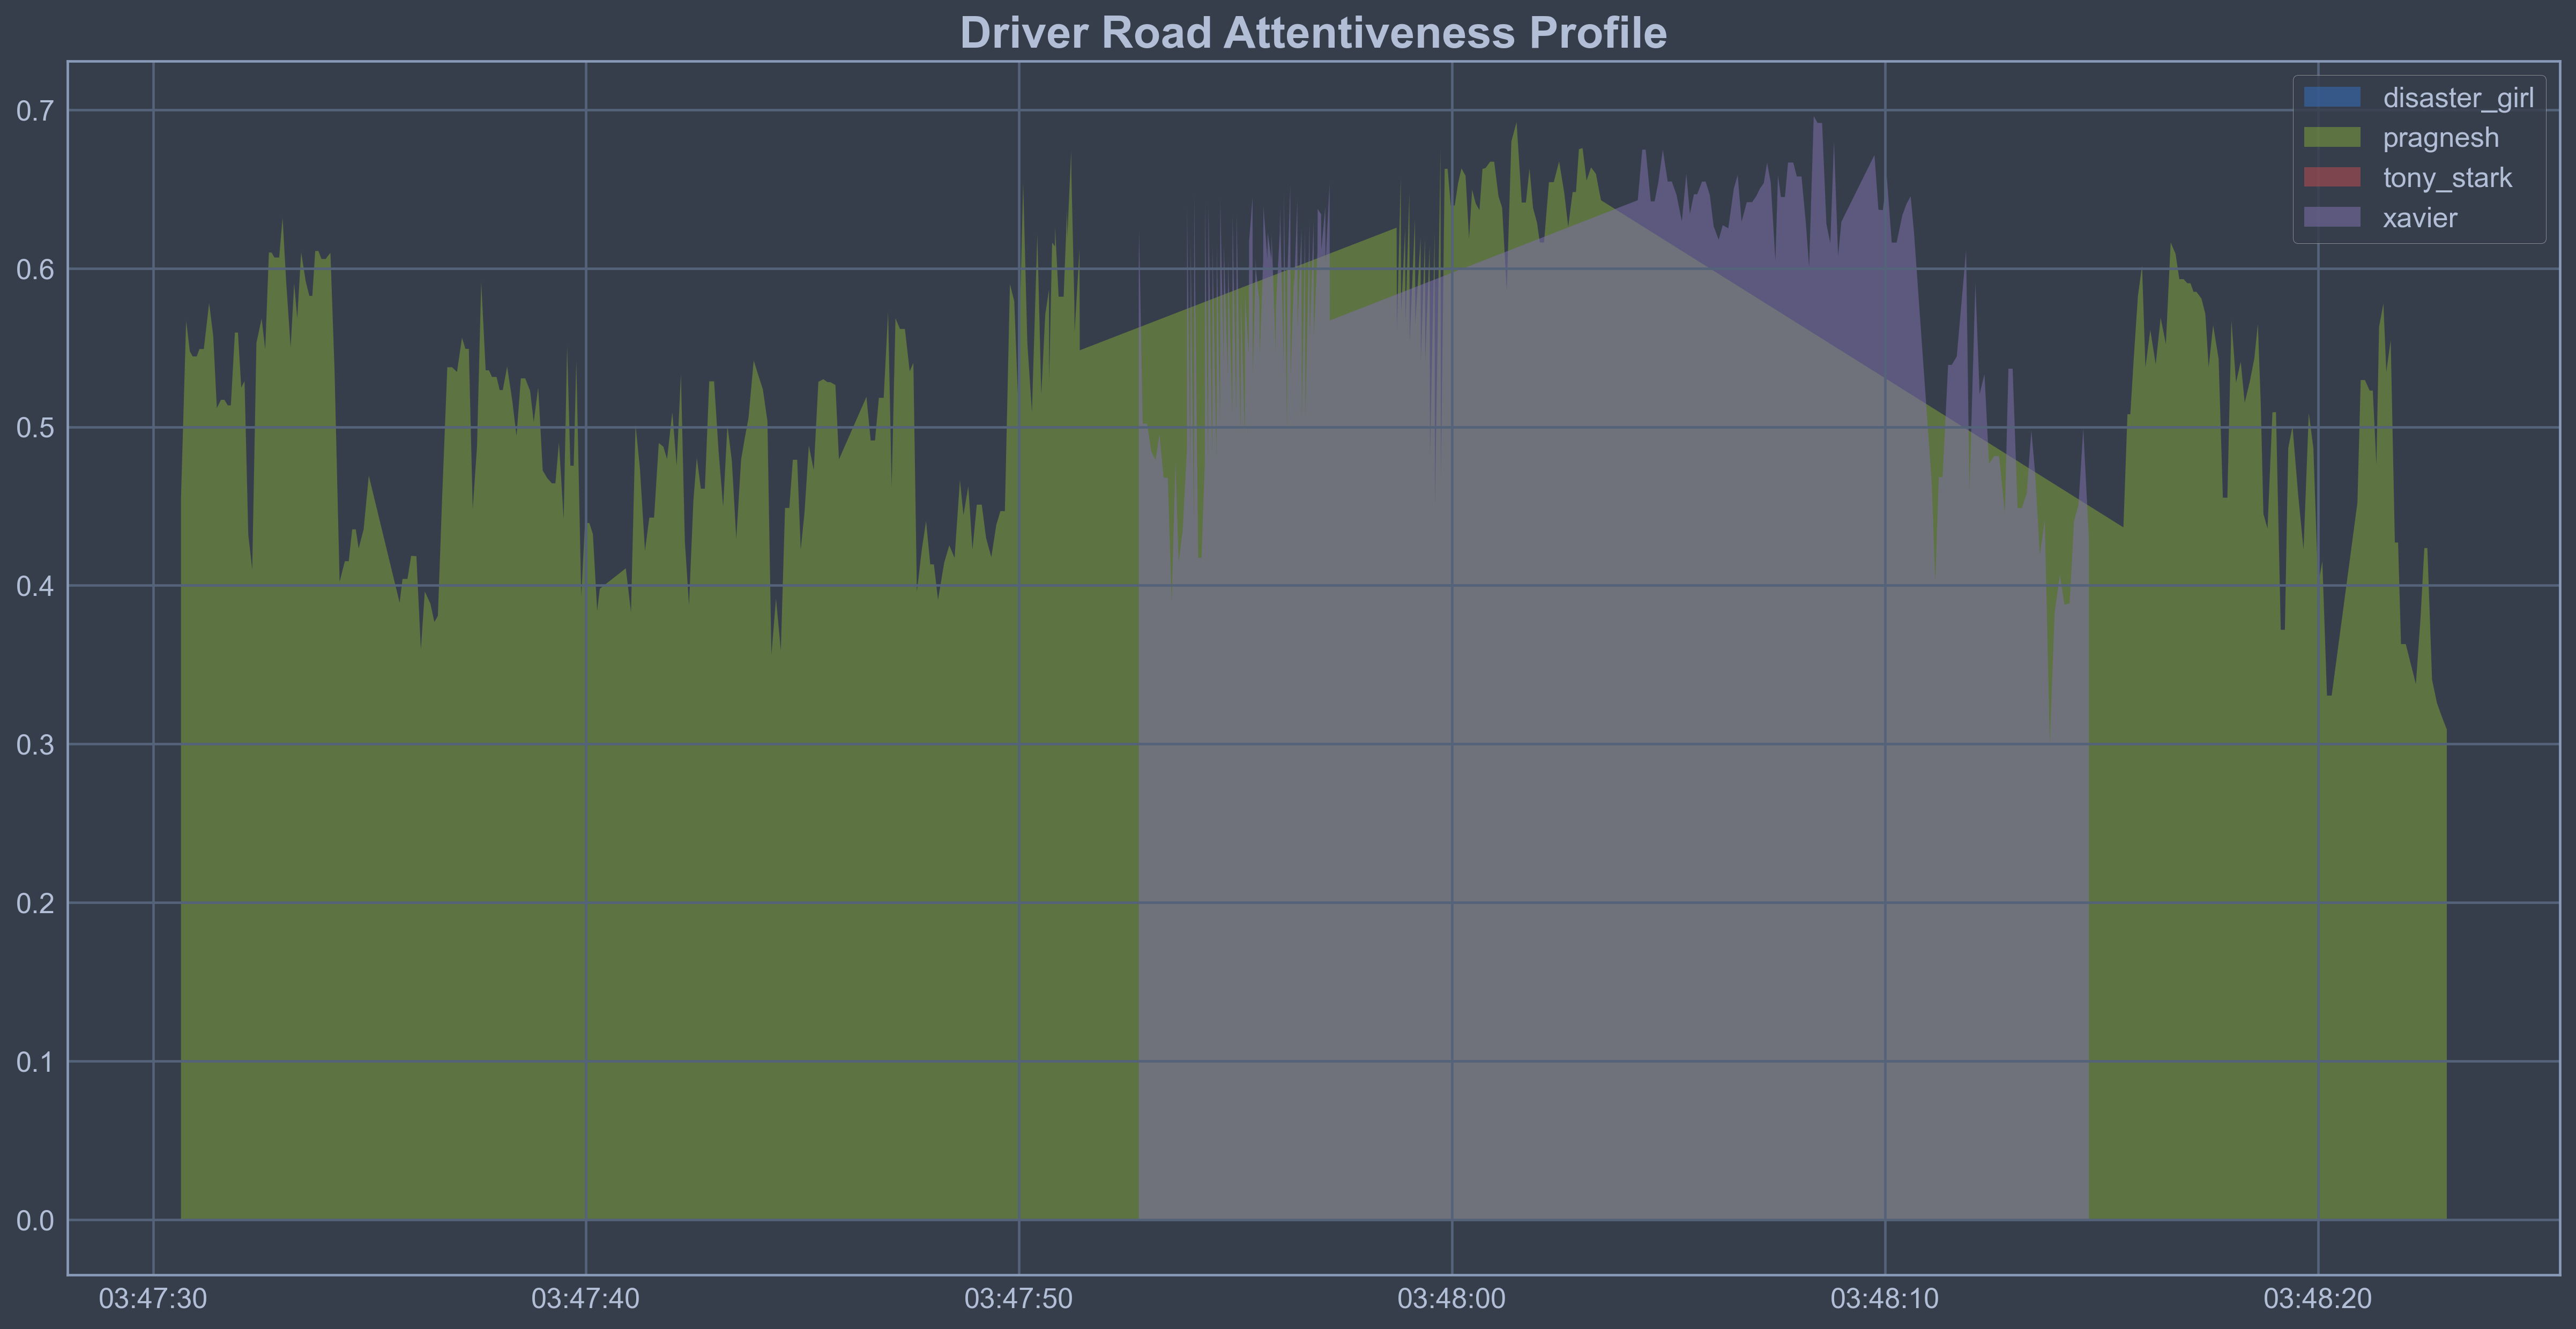

In [79]:
jtplot.style(theme='onedork')
matplotlib.rcParams['figure.dpi'] = 300
plt.figure(figsize=(20,10))
plt.title('Driver Road Attentiveness Profile', fontdict={'fontweight':'bold', 'fontsize':20})
for i in range(len(face_names)) :
    plt.fill_between(time_dict[i], ear_dict[i], label = face_names[i], alpha=0.5)
plt.legend()
plt.show()


In [ ]:
ear_dic